In [ ]:
!sudo apt install -y fluidsynth #for converting midi -> actual sound

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!pip install --upgrade pyfluidsynth #provides an interface to use fluidsynth in python

In [ ]:
!pip install pretty_midi # to create and parse/process MIDI files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=1def60dcd6ec76fb0e38a2de001932a8bdb64cfc08de0b7a76ae8ead0345c091
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
import collections #handles special container types-> dictionaries and lists
import datetime
import fluidsynth
import glob #finds file path-match
import numpy as np #numerical computations
import pathlib #manages and manipulates file system path
import pandas as pd #data analysis and manipulation
import pretty_midi
import seaborn as sns #creates statistical visuals
import tensorflow as tf #ML and deep learning tasks

from IPython import display #to display content in Jupyter notebook
from matplotlib import pyplot as plt #plots data  for visualisation
from typing import Optional #specifies optional type hints for variables

In [ ]:
seed = 42 #set seed value is a convention in ML for reproducibilty,
tf.random.set_seed(seed) #ensures tf ops. produce same rand. val. each time
np.random.seed(seed) #same for numpy

# Sampling rate for audio playback
_SAMPLING_RATE = 16000 #No. of audio samples captured/sec

In [ ]:
import tensorflow as tf
import pathlib
import zipfile

data_dir = pathlib.Path('data/maestro-v2.0.0')
zip_path = pathlib.Path(tf.keras.utils.get_file(
    'maestro-v2.0.0-midi.zip',
    origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
    cache_dir='.', cache_subdir='data'
))

# Extract manually if not already extracted
extract_path = zip_path.parent / 'maestro-v2.0.0'
if not data_dir.exists():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(zip_path.parent)

print("Download and extraction complete.")


Download and extraction complete.


In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*')) #searches dir for .mid/.midi files
print('Number of files:', len(filenames))

Number of files: 1282


In [ ]:
sample_file = filenames[1] #select a sample file to parse
print(sample_file)

data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--4.midi


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file) #creates a prettymidi obj.

In [ ]:
#Sample file playback n display
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

In [ ]:
#Name of instrument used
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
#Extraction of notes -> pitch, step, duration
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=76, note_name=E5, duration=0.1000
1: pitch=68, note_name=G#4, duration=0.0771
2: pitch=72, note_name=C5, duration=0.0854
3: pitch=75, note_name=D#5, duration=0.0687
4: pitch=80, note_name=G#5, duration=0.0521
5: pitch=72, note_name=C5, duration=0.0750
6: pitch=69, note_name=A4, duration=0.0813
7: pitch=66, note_name=F#4, duration=0.0656
8: pitch=73, note_name=C#5, duration=0.0531
9: pitch=78, note_name=F#5, duration=0.0562


In [ ]:
#Note Extraction from Sample midi file
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,76,1.003125,1.103125,0.000000,0.100000
1,72,1.093750,1.179167,0.090625,0.085417
2,68,1.097917,1.175000,0.004167,0.077083
3,75,1.179167,1.247917,0.081250,0.068750
4,80,1.243750,1.295833,0.064583,0.052083


In [ ]:
#convert numeric pitch value to note names
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10] #shows note_type, accidental, octave number

array(['E5', 'C5', 'G#4', 'D#5', 'G#5', 'C5', 'A4', 'F#4', 'C#5', 'F#5'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

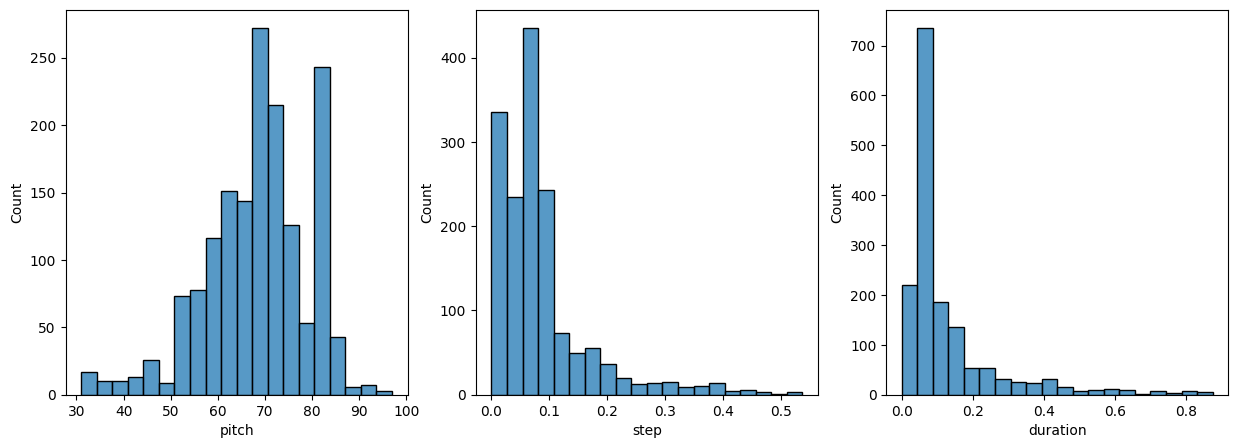

In [ ]:
plot_distributions(raw_notes)

In [ ]:
#Convert notes to midi
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

In [ ]:
#EXECUTON FROM HERE

In [ ]:
#Creation of Training dataset
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes) #no of notes parsed
print('Number of notes parsed:', n_notes)

Number of notes parsed: 16073


In [ ]:
#Dataset creation using parsed notes
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
#Train model on batches of sequences of notes w/ next note as label
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25 #No. of notes/sequence
vocab_size = 128 #midi pitches
seq_ds = create_sequences(notes_ds, seq_length, vocab_size) #Creates dataset of sequences
seq_ds.element_spec #display

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
#Prints sequence
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.515625   0.         0.38541667]
 [0.546875   0.23854167 0.18958333]
 [0.5703125  0.203125   0.20625   ]
 [0.546875   0.19791667 0.18125   ]
 [0.515625   0.19583333 0.215625  ]
 [0.5703125  0.20833333 0.203125  ]
 [0.421875   0.190625   0.26145833]
 [0.5859375  0.02395833 0.09895833]
 [0.5703125  0.12083333 0.04375   ]
 [0.5859375  0.05833333 0.10520833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=75.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.18229166666666696>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.25416666666666643>}


In [ ]:
#Batching examples
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
#Create & Train Model
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

#Loss function for step, duration to prevent o/p -ve values
loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 25, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 128)            │         67,584 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm_2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Loss eval. shows pitch loss > step, duration loss
losses = model.evaluate(train_ds, return_dict=True)
losses

250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - duration_loss: 0.1429 - loss: 5.0166 - pitch_loss: 4.8485 - step_loss: 0.0253


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.1625588834285736,
 'loss': 5.018764972686768,
 'pitch_loss': 4.8290114402771,
 'step_loss': 0.027193177491426468}

In [ ]:
#Balances loss using loss_weights arg.
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.evaluate(train_ds, return_dict=True)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - duration_loss: 0.1429 - loss: 0.4106 - pitch_loss: 4.8485 - step_loss: 0.0253


{'duration_loss': 0.1625588834285736,
 'loss': 0.4312027394771576,
 'pitch_loss': 4.8290114402771,
 'step_loss': 0.027193177491426468}

In [ ]:
#Model Training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
#No. of Epochs
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - duration_loss: 0.0808 - loss: 0.3223 - pitch_loss: 4.4522 - step_loss: 0.0189
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - duration_loss: 0.0698 - loss: 0.2901 - pitch_loss: 4.0813 - step_loss: 0.0163
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - duration_loss: 0.0694 - loss: 0.2888 - pitch_loss: 4.0625 - step_loss: 0.0163
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - duration_loss: 0.0695 - loss: 0.2869 - pitch_loss: 4.0286 - step_loss: 0.0160
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_loss: 0.0681 - loss: 0.2850 - pitch_loss: 4.0184 - step_loss: 0.0160
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_loss: 0.0669 - loss: 0.2797 - pitch_loss: 3.9260 - step_loss: 0.0165
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - duration_loss: 0.0655 - loss: 0.2764 - pitch_loss: 3.8902 - step_loss: 0.0164
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - duration_loss: 0.0627 

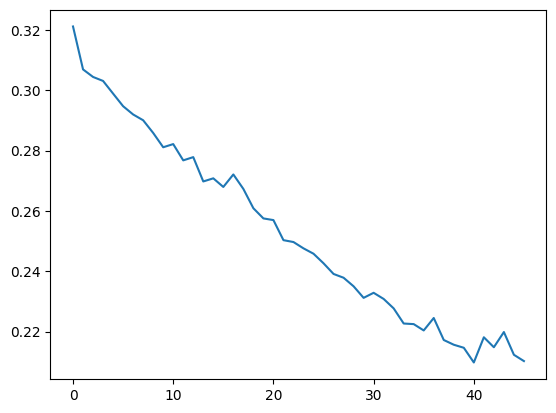

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
#Generates notes from sequence of notes
#Picks a sample from softmx distribution rather than note with highest probability as it would generate repetitive o/p
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
#Temperature to control randomness of note generated
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,69,0.088498,0.092510,0.088498,0.181008
1,61,0.491657,1.834484,0.580155,2.414638
2,76,0.372262,1.364633,0.952417,2.317049
3,81,0.543524,2.037349,1.495940,3.533290
4,71,0.478375,1.793298,1.974316,3.767613
5,79,0.472435,1.749654,2.446751,4.196405
6,41,0.525183,1.970454,2.971933,4.942387
7,83,0.386256,1.295017,3.358189,4.653206
8,71,0.544436,2.050079,3.902626,5.952704
9,83,0.427791,1.604430,4.330416,5.934846


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
from google.colab import files
files.download(out_file)